In [1]:
import numpy as np
import os
import random
from PIL import Image
from graphviz import Digraph

# Coughvid Detector

Coughvid Detector is an application to discriminate between cough due to COVID19 or another disease (or a healthy simulation) mainly based on a cough audio sample, which is flanked by other personal data and symptoms report.

At the core of this logistic classification problem are a convoluted neural network (CNN) and a random forest classifier (RFC), which are combined to predict the class label (covid or not). The audio sample is segmented using a hysteresis comparator on the signal power, preprocessed (normalized, filtered, downsampled), and fed to an extreme gradient booster (XGB) to check if it is actually a cough sample. If it is, then the preprocessed sample is converted to a spectrogram in order to be fed to the CNN. Currently the model used is just a prototype, it features a ResNet-18 architecture and parameters pre-trained on ImageNet dataset, with single-epoch head fitting and another epoch for the training, >93% accuracy on validation set. The prediction of the CNN  is then combined with the personal data and reported symptoms in order increase features and thus model accuracy (not implemented yet). Those final features should then be fed to the RFC, which does the final logistic classification.

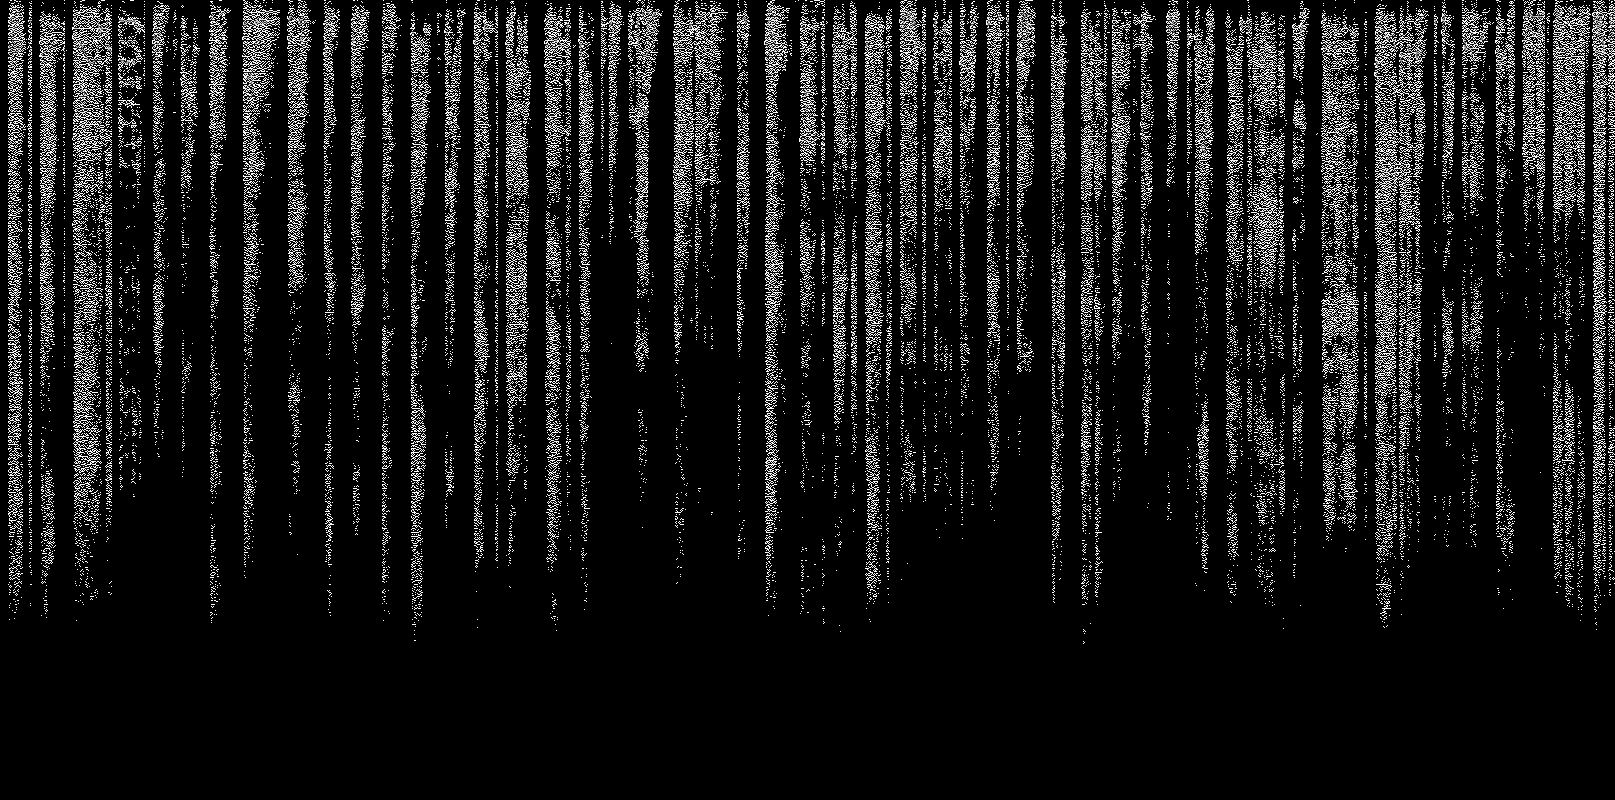

In [18]:
path = './data/extracted_images'
arrays = []
files = os.listdir(path)
rand = lambda: random.randint(0, len(files))
for i in range(50):
    img = Image.open(os.path.join(path, files[rand()]))
    arrays.append(np.array(img))
array = np.concatenate([arr for arr in arrays], axis=1)
img = Image.fromarray(array[:800, :])
display(img)

 The use of a CNN for this kind of task instead of a RNN should result in a better margin of performance, for more information see: [Rethinking CNN Models for Audio Classification](https://arxiv.org/abs/2007.11154), [Deep Convolutional Neural Networks and Data Augmentation for Environmental Sound Classification](https://arxiv.org/abs/1608.04363) and [Exploring convolutional, recurrent, and hybrid deep neural networks for speech and music detection in a large audio dataset](https://asmp-eurasipjournals.springeropen.com/articles/10.1186/s13636-019-0152-1).
 
The dataset and a the segmentation function comes from this paper: [The COUGHVID crowdsourcing dataset, a corpus for the study of large-scale cough analysis algorithms](https://www.nature.com/articles/s41597-021-00937-4), the original dataset of the paper is [here](https://zenodo.org/record/4498364), but for convenience you can find the already converted .wav version here on [Kaggle](https://www.kaggle.com/datasets/nasrulhakim86/coughvid-wav) (the original one uses .ogg and .webm formats. The official repository of the paper is [here](https://c4science.ch/diffusion/10770/)

The general logic scheme behind it is shown in the diagram below:

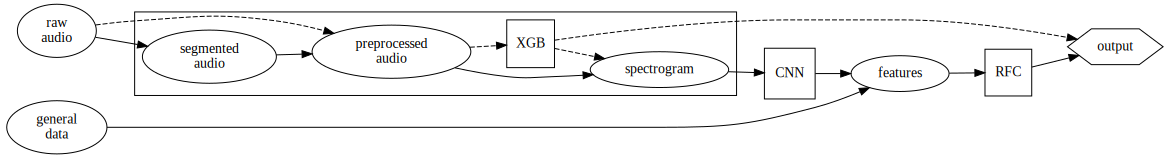

In [32]:

g = Digraph(
    graph_attr={
        'rankdir':'LR',
        'size':'20'
    }
)

with g.subgraph() as s:
    s.attr(rank='same')
    s.node('A', 'raw\naudio')
    s.node('D', 'general\ndata')

with g.subgraph(name='cluster_a') as c:
    c.node('a', 'segmented\naudio')
    c.node('b', 'preprocessed\naudio')
    c.node('c', 'XGB', shape='square')
    c.edges(['Aa', 'ab', 'bS'])
    c.edge('c', 'S', style='dashed')
    c.edge('A', 'b', style='dashed')
    c.edge('b', 'c', style='dashed')

g.node('S', 'spectrogram')
g.node('C', 'CNN', shape='square')
g.node('R', 'RFC', shape='square')
g.node('F', 'features')
g.node('O', 'output', shape='hexagon')

g.edges(['SC', 'CF', 'DF', 'FR', 'RO'])
g.edge('c', 'O', style='dashed')
# g.edge('A', 'b', style='dashed')

g


The model will be then be both deployed as a Streamlit app and as a Telegram bot running on a proud RaspberryPi2.